In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

### Load Data

In [2]:
import pandas as pd
df = pd.read_csv("./Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


### Normalization and Turning into Torch Tensors

In [3]:
x0 = torch.from_numpy(df.values[:,0:-1].astype(np.float64))
X = (x0-torch.mean(x0, dim=0))/torch.std(x0,dim=0)
Y = torch.tensor(('Abnormal'==df.values[:,-1])).int().reshape(-1,1)
print(X.shape, Y.shape)

torch.Size([310, 12]) torch.Size([310, 1])


### (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost:  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

In [4]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)

In [5]:
X

tensor([[ 1.0000,  0.1468,  0.5006,  ...,  1.1652, -1.1947,  1.7096],
        [ 1.0000, -1.2439, -0.7476,  ...,  1.6768, -0.9388, -0.9125],
        [ 1.0000,  0.4836,  0.4672,  ...,  1.6333, -1.2252, -0.6147],
        ...,
        [ 1.0000,  0.0551,  0.5148,  ..., -1.0499,  1.4410, -0.6919],
        [ 1.0000, -0.8844, -0.8842,  ..., -0.7514,  1.6212,  0.7725],
        [ 1.0000, -1.5464, -1.2458,  ...,  0.6207,  1.2953,  1.4314]],
       dtype=torch.float64)

In [6]:
X.shape

torch.Size([310, 13])

In [7]:
Y.shape

torch.Size([310, 1])

**Sigmoid function:**

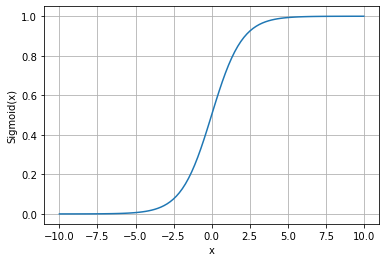

In [8]:
x = np.linspace(-10, 10, 100)
z = 1/(1 + np.exp(-x))
  
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sigmoid(x)")
plt.grid()

plt.show()

$$C(W) = -\frac{1}{N}\left(Y^T\log(\hat{Y}) + (1-Y)^T\log(1-\hat{Y})\right)$$

In [9]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def predict(X,W):
    # YOUR CODE (START)
    return torch.sigmoid(X @ W.reshape(-1, 1))
    # YOUR CODE (END)

def cost(X,Y,W):
    # YOUR CODE (START)
    N = Y.shape[0]
    Yhat = predict(X, W)
    Y = Y.type(torch.float64)
    eps = torch.empty_like(Yhat).fill_(1e-9) # to avoid log(0)
    return -1/N * (Y.T @ torch.log(torch.max(Yhat, eps)) + (1-Y).T @ torch.log(torch.max(1 - Yhat, eps)))
    # YOUR CODE (END)

$$ e = \left(\begin{array}{c} e_1 \\ \vdots \\ e_N \end{array}\right) = \left(\begin{array}{c} 1 \\ \vdots \\ 1 \end{array}\right)$$

$$\nabla_W C = -\frac{1}{N}\left(Y^T \frac{1}{\hat{Y}} \nabla\hat{Y} - (e-Y)^T \frac{1}{e-\hat{Y}} \nabla\hat{Y}\right)$$

$$\nabla_W\hat{Y} = \hat{Y}\circ(e - \hat{Y}) \circ X$$

$$\begin{align}
\nabla_W C &= -\frac{1}{N}\left( Y^T ((e-\hat{Y}) \circ X) - (e-Y)^T (\hat{Y} \circ X)\right) \\
&= -\frac{1}{N}\left( Y^T X - Y^T (\hat{Y} \circ X) - e^T (\hat{Y} \circ X) + Y^T (\hat{Y} \circ  X)\right)\\
&= -\frac{1}{N}\left(Y - \hat{Y}\right)^T X
\end{align}$$

In [10]:
def gradient_cost(X,Y,W):
    # YOUR CODE (START)
    #W = W.reshape(-1, 1)
    N = Y.shape[0]
    Y = Y.type(torch.float64)
    Yhat = predict(X, W)
    return -1/N * (Y - Yhat).T @ X
    # YOUR CODE (END)
    
def accuracy(Y,Yhat):
    # YOUR CODE (START)
    return torch.sum(1 - torch.abs(Y - Yhat.round())) / Y.shape[0]
    # YOUR CODE (END)

Just for testing:

In [11]:
W = torch.randn((1,13), dtype=torch.double)
print(predict(X[0],W))
print(cost(X,Y,W))
print(gradient_cost(X,Y,W))
print(accuracy(Y,predict(X,W)))

tensor([0.9949], dtype=torch.float64)
tensor([[1.8395]], dtype=torch.float64)
tensor([[-0.0925, -0.4407, -0.3185, -0.4229, -0.3284,  0.1454, -0.4092, -0.0756,
         -0.0067, -0.0456, -0.0318, -0.1293,  0.1136]], dtype=torch.float64)
tensor(0.4226, dtype=torch.float64)


### Training

Training Accuracy (max,end): 0.864516, 0.861290
Training Cost (end): 0.308136


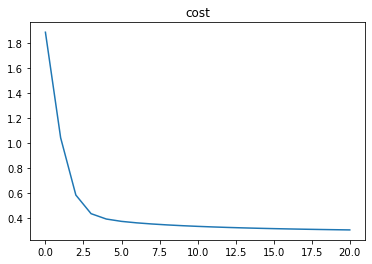

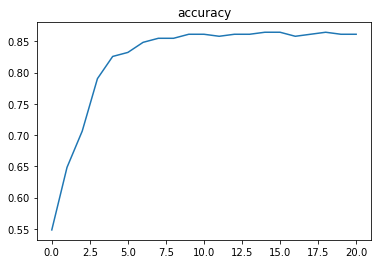

In [12]:
# adjust if needed
nepochs = 20
lr = 5

## initial parameter
W = torch.randn((1,13), dtype=torch.double)

# track the costs
costs = [cost(X,Y,W).item()]
accs = [accuracy(Y,predict(X,W))]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    W = W - lr * gradient_cost(X, Y, W)
    costs.append(cost(X,Y,W).item())
    accs.append(accuracy(Y,predict(X,W)))

# YOUR CODE (END)
    
# some output
accs = np.array(accs)

print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
print("Training Cost (end): %f"%costs[-1])
plt.figure(1)
plt.title("cost")
plt.plot(range(nepochs+1),costs)
plt.figure(2)
plt.title("accuracy")
plt.plot(range(nepochs+1),accs)

### Different Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

--- Learning Rate: 1.000000
Training Accuracy (max,end): 0.861290 @ 11, 0.861290
Training Cost (end): 0.331452


--- Learning Rate: 2.000000
Training Accuracy (max,end): 0.851613 @ 17, 0.848387
Training Cost (end): 0.358375


--- Learning Rate: 3.000000
Training Accuracy (max,end): 0.867742 @ 20, 0.867742
Training Cost (end): 0.325673


--- Learning Rate: 4.000000
Training Accuracy (max,end): 0.861290 @ 12, 0.858065
Training Cost (end): 0.312832


--- Learning Rate: 5.000000
Training Accuracy (max,end): 0.870968 @ 10, 0.858065
Training Cost (end): 0.305342


--- Learning Rate: 6.000000
Training Accuracy (max,end): 0.864516 @ 13, 0.838710
Training Cost (end): 0.324716


--- Learning Rate: 7.000000
Training Accuracy (max,end): 0.848387 @ 20, 0.848387
Training Cost (end): 0.342489


--- Learning Rate: 8.000000
Training Accuracy (max,end): 0.812903 @ 17, 0.809677
Training Cost (end): 0.412431


--- Learning Rate: 9.000000
Training Accuracy (max,end): 0.812903 @ 4, 0.812903
Training Cost (e

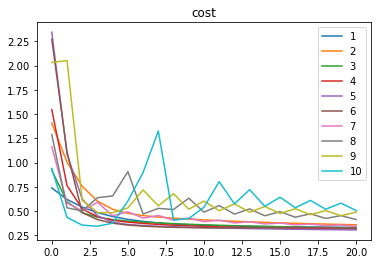

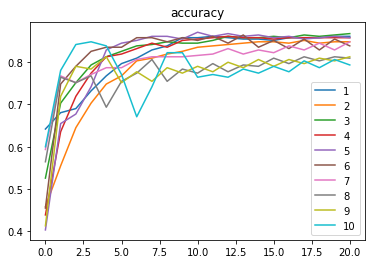

In [13]:
# adjust if needed
nepochs = 20
lrs = np.arange(1, 11, 1)

## initial parameter
torch.manual_seed(42)
all_costs = []
all_accs = []

for lr in lrs: 
    W = torch.randn((1,13), dtype=torch.double)

    # track the costs
    costs = [cost(X,Y,W).item()]
    accs = [accuracy(Y,predict(X,W))]

    # YOUR CODE (START)

    # loop over the epochs: update parameter values, compute the cost and add it to the costs list
    for epoch in range(nepochs):
        W = W - lr * gradient_cost(X, Y, W)
        costs.append(cost(X,Y,W).item())
        accs.append(accuracy(Y,predict(X,W)))

    # YOUR CODE (END)

    # some output
    accs = np.array(accs)
    
    print("--- Learning Rate: %f"% lr)
    print("Training Accuracy (max,end): %f @ %d, %f"%(np.max(accs), np.argmax(accs), accs[-1]))
    print("Training Cost (end): %f"%costs[-1])
    print("\n")
    
    all_costs.append(costs)
    all_accs.append(accs)
    
plt.figure(1)
plt.title("cost")

for idx, lr in enumerate(lrs):
    plt.plot(range(nepochs+1),all_costs[idx],label=lr)
    
plt.legend()

plt.figure(2)
plt.title("accuracy")

for idx, lr in enumerate(lrs):
    plt.plot(range(nepochs+1),all_accs[idx],label=lr)
    
plt.legend()

$lr < 5:\;$ achieves an accuracy over $0.84$ \
$lr = 3:\;$ finds the max end accuracy of $\approx 0.868$ \
$lr \approx 5:\;$ seems to find the max accuracy of $\approx 0.87$ after only $10$ iterations, thus converges the fastest \
$lr > 5:\;$ overshoots and therefore causes jitter, easily observable especially with $lr >= 8$